In [37]:
import pandas as pd
import networkx as nx
import community
from collections import defaultdict
import csv
import matplotlib.pyplot as plt

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Create Network

In [39]:
# Load the paper-author relationships
df_paper_author = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/paper_author.csv")

G_coauthor = nx.Graph()

# Add all authors as nodes first
unique_authors = df_paper_author["author_id"].unique()
G_coauthor.add_nodes_from(unique_authors)

# Group by paper to get a list of authors for each paper
paper_groups = df_paper_author.groupby("paper_id")["author_id"].apply(list)

# For each paper, add edges between all pairs of authors if multiple authors exist
for paper, authors in paper_groups.items():
    # Skip papers with single authors (they're already nodes)
    if len(authors) < 2:
        continue
    # Create edges between all pairs of authors in the paper
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            author1, author2 = authors[i], authors[j]
            if G_coauthor.has_edge(author1, author2):
                # Increment weight if edge already exists
                G_coauthor[author1][author2]["weight"] += 1
            else:
                G_coauthor.add_edge(author1, author2, weight=1)

# Add author names as node attributes
df_authors = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/author.csv")
author_names = dict(zip(df_authors["node_id"], df_authors["name"]))
nx.set_node_attributes(G_coauthor, author_names, "name")

# Print basic info about the co-authorship network
print("Co-Authorship Network:")
print("Number of author nodes:", G_coauthor.number_of_nodes())
print("Number of co-authorship links:", G_coauthor.number_of_edges())

# Example: Print first 5 edges with weights
print("\nSample of co-authorship edges with weights:")
for edge in list(G_coauthor.edges(data=True))[:5]:
    print(edge)


Co-Authorship Network:
Number of author nodes: 18522
Number of co-authorship links: 241405

Sample of co-authorship edges with weights:
('author_1', 'author_2', {'weight': 1})
('author_2', 'author_9496', {'weight': 1})
('author_2', 'author_3432', {'weight': 2})
('author_2', 'author_3434', {'weight': 2})
('author_2', 'author_3141', {'weight': 2})


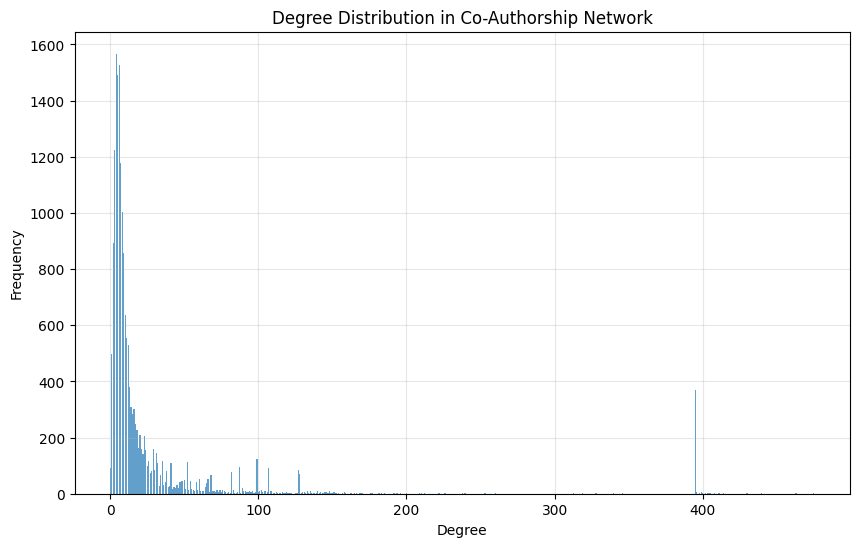


Degree Statistics:
Average degree: 26.07
Maximum degree: 475
Minimum degree: 0


In [40]:
# Calculate degree distribution
degrees = [d for n, d in G_coauthor.degree()]
degree_counts = pd.Series(degrees).value_counts().sort_index()

# Plot degree distribution as bar chart
plt.figure(figsize=(10, 6))
plt.bar(degree_counts.index, degree_counts.values, alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution in Co-Authorship Network')
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic degree statistics
print("\nDegree Statistics:")
print(f"Average degree: {sum(degrees)/len(degrees):.2f}")
print(f"Maximum degree: {max(degrees)}")
print(f"Minimum degree: {min(degrees)}")


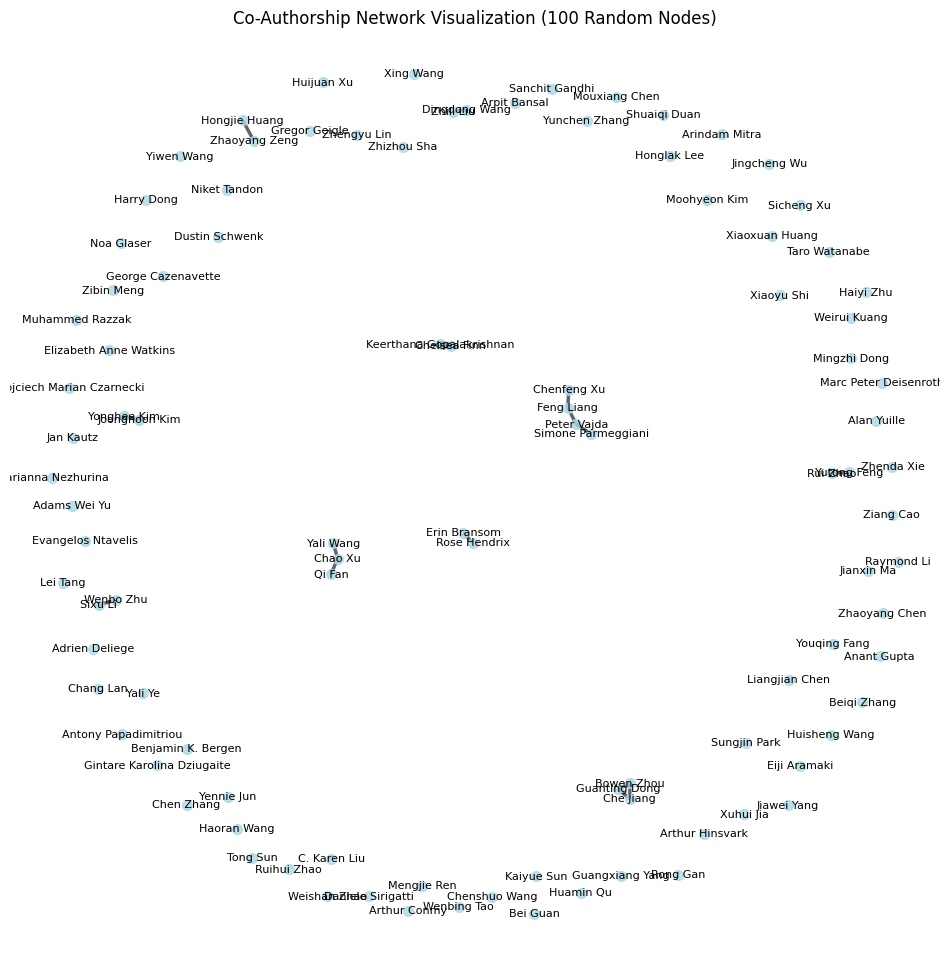

In [41]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# Assuming G_coauthor has been created from your paper-author data

# Extract the largest connected component
largest_cc = max(nx.connected_components(G_coauthor), key=len)
G_lcc = G_coauthor.subgraph(largest_cc).copy()

# Randomly sample 100 nodes
sample_nodes = random.sample(list(G_lcc.nodes()), min(100, len(G_lcc.nodes())))
G_sample = G_lcc.subgraph(sample_nodes).copy()

# Use a spring layout for visualization (seed for reproducibility)
pos = nx.spring_layout(G_sample, seed=42)

# Draw nodes with a fixed small size
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_sample, pos, node_size=50, node_color='lightblue', alpha=0.8)

# Scale edge widths based on the 'weight' attribute
edges = G_sample.edges(data=True)
edge_weights = [data['weight'] for (_, _, data) in edges]
max_weight = max(edge_weights) if edge_weights else 1
# Normalize edge widths (scaling factor can be adjusted)
edge_widths = [max(0.1, (w / max_weight * 5)) for w in edge_weights]

nx.draw_networkx_edges(G_sample, pos, width=edge_widths, alpha=0.6)

# Draw labels for all nodes
labels = {node: G_sample.nodes[node].get("name", node) for node in G_sample.nodes()}
nx.draw_networkx_labels(G_sample, pos, labels, font_size=8)

plt.title("Co-Authorship Network Visualization (100 Random Nodes)")
plt.axis('off')
plt.show()


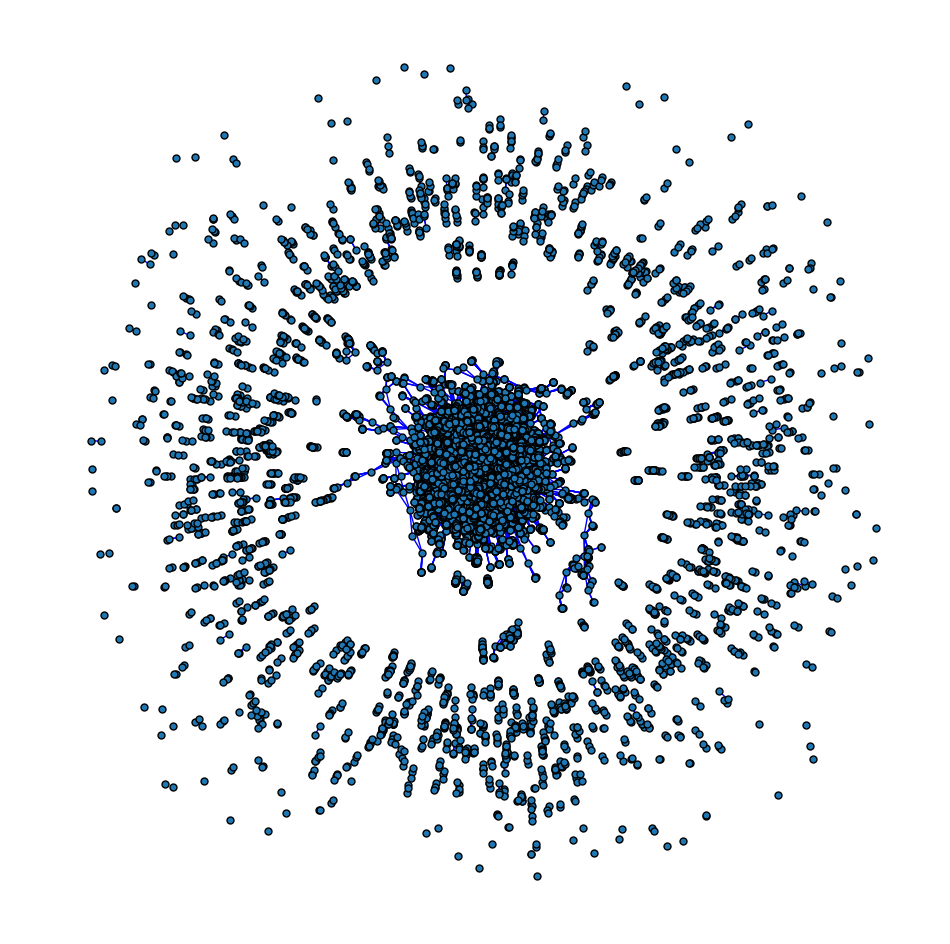

In [42]:
#pos = nx.nx_pydot.graphviz_layout(G_coauthor, prog='dot')
plt.figure(figsize=(12, 12))
plt.axis('off')
nx.draw_networkx(G_coauthor, pos= nx.spring_layout(G_coauthor, iterations=30), with_labels=False, node_size=25, edgecolors='black', edge_color='b')
plt.show()

#Compute Metrics

##Degree, Betweenness, PageRank

In [ ]:
# Degree Centrality
#degree_centrality = nx.degree_centrality(G_coauthor)

weighted_degree = {}
for node in G_coauthor.nodes():
    wdeg = sum(data["weight"] for _, _, data in G_coauthor.edges(node, data=True))
    weighted_degree[node] = wdeg

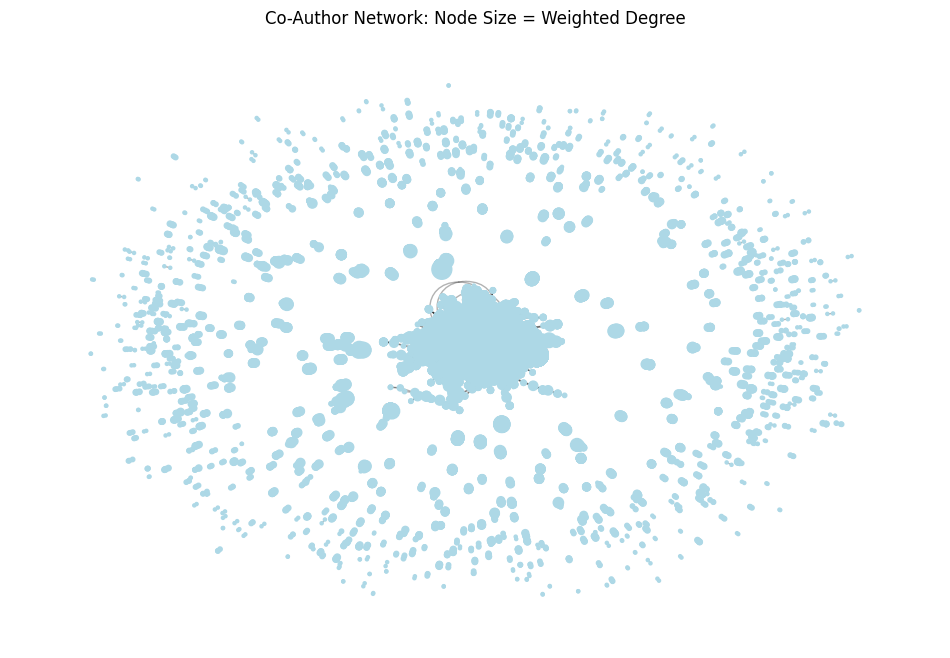

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.spring_layout(G_coauthor, seed=42)

# Map weighted degree to node size
sizes = []
for node in G_coauthor.nodes():
    wdeg = weighted_degree[node]
    sizes.append(wdeg * 5)  # scale factor

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_coauthor, pos, node_size=sizes, node_color="lightblue")
nx.draw_networkx_edges(G_coauthor, pos, alpha=0.3)
plt.title("Co-Author Network: Node Size = Weighted Degree")
plt.axis("off")
plt.show()


<Figure size 1200x800 with 0 Axes>

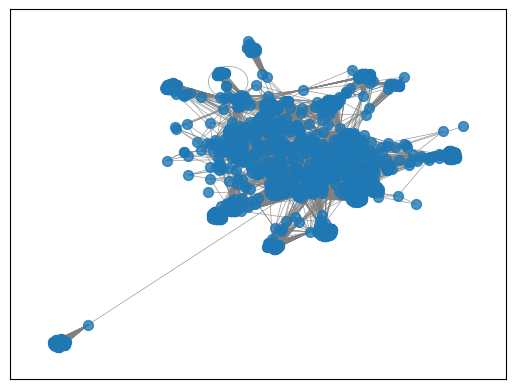

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Example: keep only nodes with weighted_degree > 50
nodes_to_keep = [n for n in G_coauthor if weighted_degree[n] > 50]
G_sub = G_coauthor.subgraph(nodes_to_keep).copy()

pos_sub = nx.spring_layout(G_sub, seed=42)
nx.draw_networkx_nodes(G_sub, pos_sub, node_size=50, alpha=0.8)
nx.draw_networkx_edges(G_sub, pos_sub, edge_color="gray", width=0.5, alpha=0.8)
plt.figure(figsize=(12, 8))


In [ ]:
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G_coauthor, weight="weight", k=1000)

In [ ]:
# PageRank (choose one) OR Eigenvector Centrality
pagerank = nx.pagerank(G_coauthor, weight="weight")
# OR
# eigenvector_centrality = nx.eigenvector_centrality(G_coauthor, weight="weight", max_iter=500)

In [ ]:
# Convert centralities to DataFrames
df_wdeg = pd.DataFrame(list(weighted_degree.items()), columns=["node", "weighted_degree"])
df_bc = pd.DataFrame(list(betweenness_centrality.items()), columns=["node", "betweenness_centrality"])
df_pr = pd.DataFrame(list(pagerank.items()), columns=["node", "pagerank"])

# If Eigenvector instead of PageRank:
# df_ec = pd.DataFrame(list(eigenvector_centrality.items()), columns=["node", "eigenvector_centrality"])

# Merge them into one DataFrame
df_centralities = df_wdeg.merge(df_bc, on="node").merge(df_pr, on="node")
# If using Eigenvector, merge that as well:
# df_centralities = df_centralities.merge(df_ec, on="node")

# Optional: If your graph nodes have an attribute "name", let's add that too
# e.g., if G_coauthor.nodes[node]["name"] = author_name
names = []
for node in df_centralities["node"]:
    author_name = G_coauthor.nodes[node].get("name", str(node))  # fallback to node ID if name missing
    names.append(author_name)
df_centralities["author_name"] = names

# Sort the combined DataFrame by degree centrality (descending)
df_centralities.sort_values("weighted_degree", ascending=False, inplace=True)

# Show top 10 authors by degree centrality
print("\nTop 10 Authors by Degree Centrality:")
print(df_centralities[["author_name", "weighted_degree"]].head(10))

# Show top 10 by betweenness
df_centralities.sort_values("betweenness_centrality", ascending=False, inplace=True)
print("\nTop 10 Authors by Betweenness Centrality:")
print(df_centralities[["author_name", "betweenness_centrality"]].head(10))

# Show top 10 by PageRank
df_centralities.sort_values("pagerank", ascending=False, inplace=True)
print("\nTop 10 Authors by PageRank:")
print(df_centralities[["author_name", "pagerank"]].head(10))

# If you computed Eigenvector Centrality, you can do:
# df_centralities.sort_values("eigenvector_centrality", ascending=False, inplace=True)
# print("\nTop 10 Authors by Eigenvector Centrality:")
# print(df_centralities[["author_name", "eigenvector_centrality"]].head(10))



Top 10 Authors by Degree Centrality:
         author_name  weighted_degree
1140         Yu Qiao              561
9739      Tianyu Liu              512
2674       Dahua Lin              489
7270        Lei Wang              476
440           Wei Li              447
1678         Jing Xu              442
960    Kyunghyun Cho              431
855       Jamin Shin              415
10789        Bo Zeng              414
10787    Youngjae Yu              412

Top 10 Authors by Betweenness Centrality:
             author_name  betweenness_centrality
1140             Yu Qiao                0.021639
8391  Niklas Muennighoff                0.019451
7640                   :                0.018263
440               Wei Li                0.017944
954             Ge Zhang                0.016251
1267            Rui Wang                0.015548
2711           Hao Zhang                0.013957
51              Fan Yang                0.013613
2558             Peng Xu                0.012508
2592       

In [ ]:
# Save to CSV
df_centralities.to_csv("/content/drive/MyDrive/daily-papers-analysis/measures/coauthor_centralities.csv", index=False)

# Or save to JSON
df_centralities.to_json("/content/drive/MyDrive/daily-papers-analysis/measures/coauthor_centralities.json", orient="records")

###Visualization

In [43]:
df_centralities = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/measures/coauthor_centralities.csv")

# Sort by weighted_degree, pick top 10
df_top_degree = df_centralities.sort_values("weighted_degree", ascending=False).head(10)

# Sort by betweenness_centrality, pick top 10
df_top_betweenness = df_centralities.sort_values("betweenness_centrality", ascending=False).head(10)

# Sort by pagerank, pick top 10
df_top_pagerank = df_centralities.sort_values("pagerank", ascending=False).head(10)

<ipython-input-44-75358666290d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-44-75358666290d>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-44-75358666290d>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


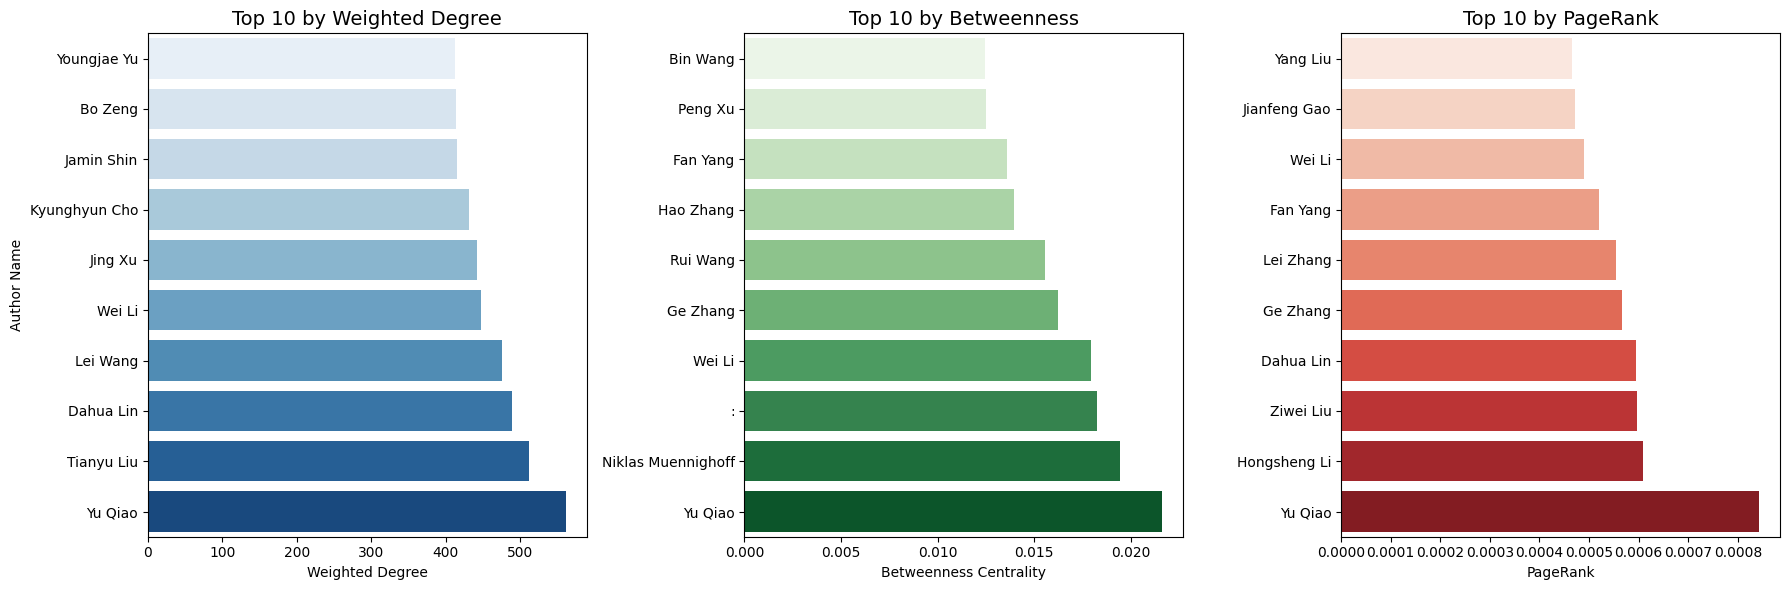

In [44]:
#Side-by-side

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Subplot 1: Weighted Degree ---
sns.barplot(
    data=df_top_degree,
    x="weighted_degree",
    y="author_name",
    palette="Blues_r",
    ax=axes[0]
)
axes[0].set_title("Top 10 by Weighted Degree", fontsize=14)
axes[0].set_xlabel("Weighted Degree")
axes[0].set_ylabel("Author Name")
axes[0].invert_yaxis()  # put highest at top

# --- Subplot 2: Betweenness Centrality ---
sns.barplot(
    data=df_top_betweenness,
    x="betweenness_centrality",
    y="author_name",
    palette="Greens_r",
    ax=axes[1]
)
axes[1].set_title("Top 10 by Betweenness", fontsize=14)
axes[1].set_xlabel("Betweenness Centrality")
axes[1].set_ylabel("")
axes[1].invert_yaxis()

# --- Subplot 3: PageRank ---
sns.barplot(
    data=df_top_pagerank,
    x="pagerank",
    y="author_name",
    palette="Reds_r",
    ax=axes[2]
)
axes[2].set_title("Top 10 by PageRank", fontsize=14)
axes[2].set_xlabel("PageRank")
axes[2].set_ylabel("")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

<ipython-input-45-caa0bef44c76>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


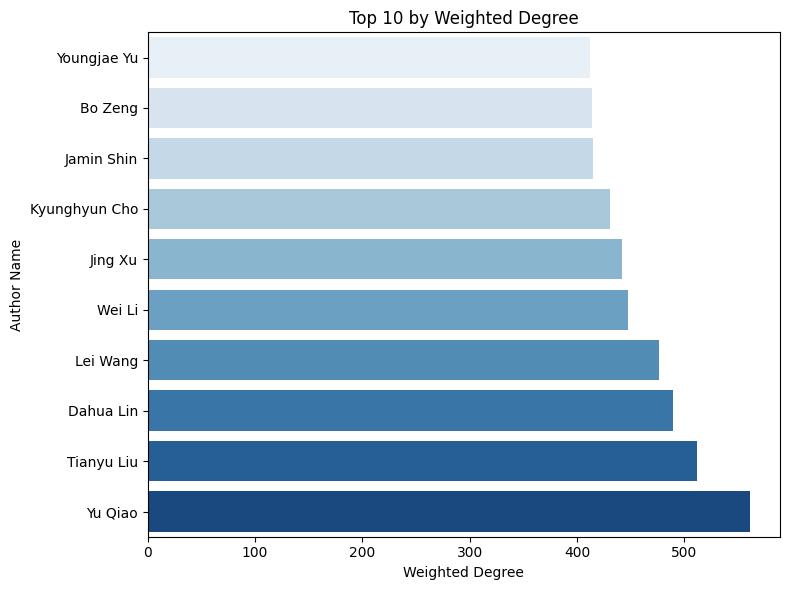

<ipython-input-45-caa0bef44c76>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


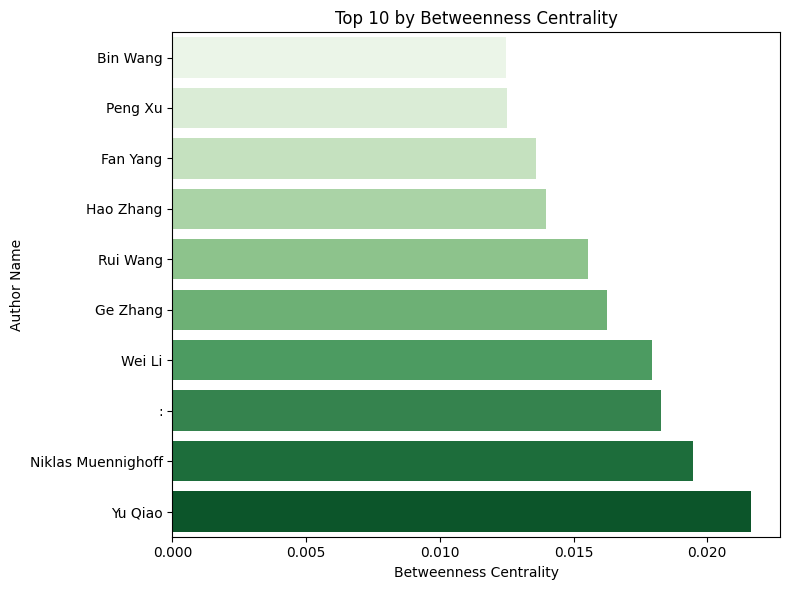

<ipython-input-45-caa0bef44c76>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


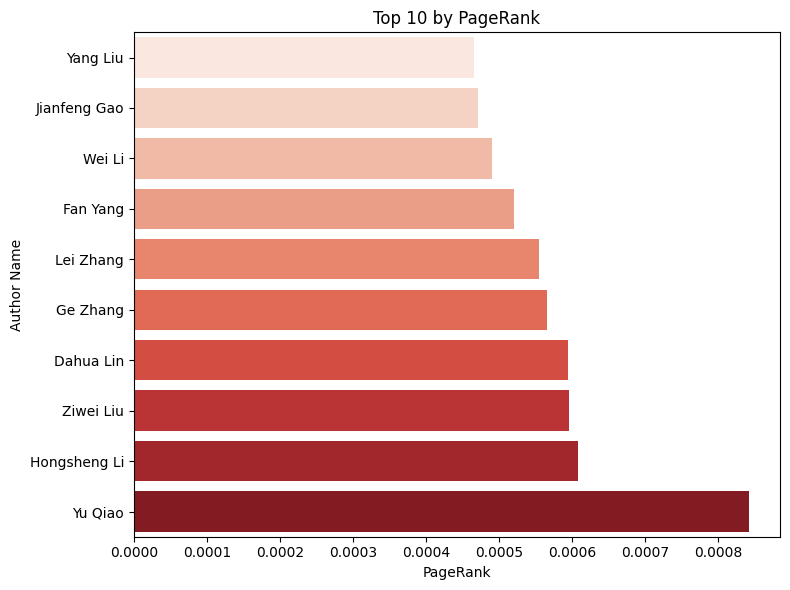

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Weighted Degree (new figure) ---
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_top_degree,
    x="weighted_degree",
    y="author_name",
    palette="Blues_r"
)
plt.title("Top 10 by Weighted Degree")
plt.xlabel("Weighted Degree")
plt.ylabel("Author Name")
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()

# --- Betweenness (new figure) ---
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_top_betweenness,
    x="betweenness_centrality",
    y="author_name",
    palette="Greens_r"
)
plt.title("Top 10 by Betweenness Centrality")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Author Name")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- PageRank (new figure) ---
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_top_pagerank,
    x="pagerank",
    y="author_name",
    palette="Reds_r"
)
plt.title("Top 10 by PageRank")
plt.xlabel("PageRank")
plt.ylabel("Author Name")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##Modularity

In [ ]:
! pip install python-louvain

In [ ]:
# Extract the largest connected component
largest_cc = max(nx.connected_components(G_coauthor), key=len)
G_lcc = G_coauthor.subgraph(largest_cc).copy()

# Find the best partition (dictionary of node -> community_id)
partition = community.best_partition(G_lcc)

# Compute the modularity based on this partition
modularity_value = community.modularity(partition, G_lcc)

print("Modularity of the co-authorship network:", modularity_value)

#(above 0.4 or 0.5): The network has distinct clusters where nodes within each cluster are more densely connected than to the rest of the graph.
#(close to 0): The network has weak or no clear community structure.

Modularity of the co-authorship network: 0.8143245606689777


##Community

In [ ]:
# Invert partition -> {community_id: [nodes]}
communities_dict = defaultdict(list)
for node, comm_id in partition.items():
    communities_dict[comm_id].append(node)

# Print community info
print("Number of communities:", len(communities_dict))
for cid, members in communities_dict.items():
    print(f"Community {cid}: {len(members)} nodes")

# Save the partition to CSV (node -> community_id)
with open("/content/drive/MyDrive/daily-papers-analysis/measures/coauthor_partition.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["node", "community_id"])
    for node, comm_id in partition.items():
        writer.writerow([node, comm_id])

# Save the communities to CSV (community_id -> list_of_nodes)
with open("/content/drive/MyDrive/daily-papers-analysis/measures/coauthor_communities.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["community_id", "nodes"])
    for cid, members in communities_dict.items():
        nodes_str = ",".join(str(node) for node in members)
        writer.writerow([cid, nodes_str])

print("\nSaved community detection results to:")
print(" - coauthor_partition.csv")
print(" - coauthor_communities.csv")

Number of communities: 53
Community 15: 238 nodes
Community 37: 1174 nodes
Community 23: 239 nodes
Community 3: 325 nodes
Community 4: 217 nodes
Community 5: 556 nodes
Community 6: 304 nodes
Community 7: 827 nodes
Community 8: 519 nodes
Community 9: 367 nodes
Community 13: 431 nodes
Community 11: 465 nodes
Community 12: 119 nodes
Community 14: 378 nodes
Community 17: 324 nodes
Community 18: 553 nodes
Community 19: 526 nodes
Community 51: 356 nodes
Community 21: 401 nodes
Community 27: 399 nodes
Community 24: 26 nodes
Community 28: 556 nodes
Community 29: 250 nodes
Community 30: 290 nodes
Community 31: 122 nodes
Community 32: 729 nodes
Community 45: 180 nodes
Community 34: 203 nodes
Community 35: 216 nodes
Community 36: 151 nodes
Community 38: 339 nodes
Community 39: 235 nodes
Community 40: 393 nodes
Community 41: 858 nodes
Community 42: 6 nodes
Community 43: 406 nodes
Community 44: 209 nodes
Community 46: 22 nodes
Community 47: 98 nodes
Community 48: 25 nodes
Community 49: 36 nodes
Com

###Visualization

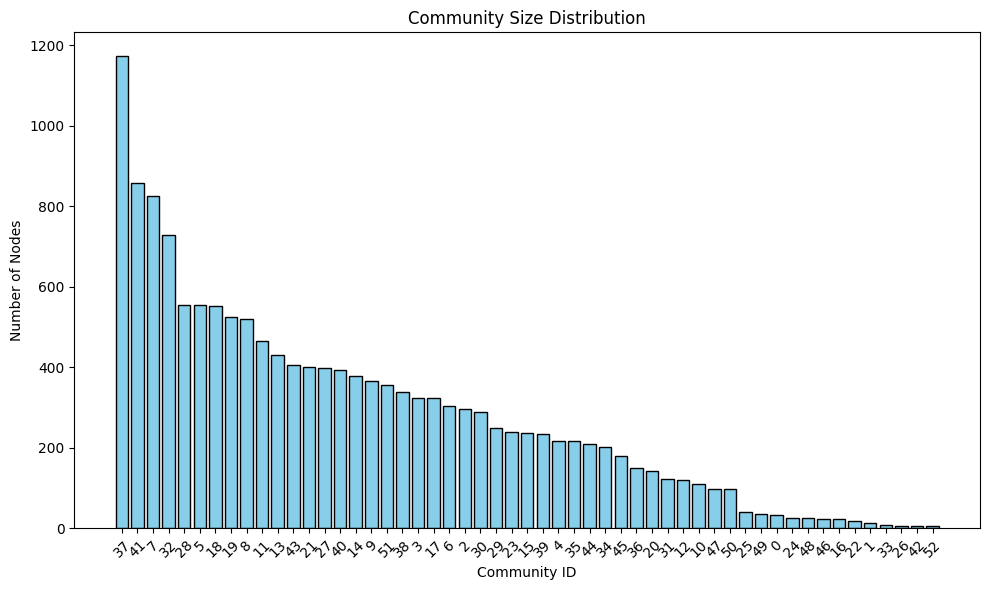

In [46]:
# Load coauthor_communities.csv
df_communities = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/measures/coauthor_communities.csv")

# Each row has community_id and a comma-separated list of nodes
# Compute size by splitting the 'nodes' column
df_communities["size"] = df_communities["nodes"].apply(lambda x: len(str(x).split(",")))

# Sort by size descending
df_communities.sort_values("size", ascending=False, inplace=True)

# Bar chart of community sizes
plt.figure(figsize=(10, 6))
plt.bar(df_communities["community_id"].astype(str), df_communities["size"], color="skyblue", edgecolor="black")
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.title("Community Size Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [47]:
import csv

df_comm = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/measures/coauthor_communities.csv")
# Suppose it has columns: ["community_id", "nodes"]

# Convert comma-separated 'nodes' into a list
df_comm["author_list"] = df_comm["nodes"].apply(lambda x: str(x).split(","))

# Compute the size of each community
df_comm["size"] = df_comm["author_list"].apply(len)

# Sort by size descending
df_comm.sort_values("size", ascending=False, inplace=True)

top_5_communities = df_comm.head(5).copy()
print(top_5_communities[["community_id", "size"]])

    community_id  size
1             37  1174
33            41   858
7              7   827
25            32   729
21            28   556


In [48]:
df_paper_author = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/paper_author.csv")          # [paper_id, author_id]
df_paper_org = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/paper_organization.csv")    # [paper_id, organization_id]
df_org = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/organization.csv")          # [node_id, name]


In [49]:
def get_papers_for_authors(author_list, df_paper_author):
    """
    Returns a set of paper_ids for all authors in 'author_list'.
    """
    subset = df_paper_author[df_paper_author["author_id"].isin(author_list)]
    return set(subset["paper_id"].unique())

def get_organizations_for_papers(paper_ids, df_paper_org):
    """
    Returns a set of organization_ids for the given paper_ids.
    """
    subset = df_paper_org[df_paper_org["paper_id"].isin(paper_ids)]
    return set(subset["organization_id"].unique())

def get_org_names(org_ids, df_org):
    """
    Returns a list of organization names for the given org_ids.
    """
    subset = df_org[df_org["node_id"].isin(org_ids)]
    return subset["name"].unique().tolist()

for idx, row in top_5_communities.iterrows():
    comm_id = row["community_id"]
    authors_in_comm = row["author_list"]  # a list of author IDs (strings)
    size = row["size"]

    # Step A: gather paper IDs
    paper_ids = get_papers_for_authors(authors_in_comm, df_paper_author)

    # Step B: gather organization IDs
    org_ids = get_organizations_for_papers(paper_ids, df_paper_org)

    # Step C: get organization names
    org_names = get_org_names(org_ids, df_org)

    print(f"\nCommunity {comm_id} (size={size}) has {len(org_names)} organizations:")
    # Print the first 10 for brevity
    for name in org_names[:10]:
        print("   ", name)



Community 37 (size=1174) has 552 organizations:
    New York University
    J.P. Morgan AI Research
    Department of Electrical and Computer Engineering
    Ingenuity Labs Research Institute
    University of Surrey
    Georgia Institute of Technology
    Microsoft
    Peking University
    University of Maryland
    Washington University in St. Louis

Community 41 (size=858) has 525 organizations:
    New York University
    Northwestern University
    University of Surrey
    Georgia Institute of Technology
    Microsoft
    Peking University
    University of Maryland
    University of California, Berkeley
    Google Research
    Adobe Research

Community 7 (size=827) has 421 organizations:
    New York University
    J.P. Morgan AI Research
    University of Surrey
    Microsoft
    Peking University
    University of Maryland
    Washington University in St. Louis
    University of California, Berkeley
    Google Research
    KAIST

Community 32 (size=729) has 464 organizations:

In [50]:
def get_org_frequencies(paper_ids, df_paper_org, df_org):
    """
    Returns a DataFrame of [organization_name, paper_count],
    sorted descending by how many papers that org is on.
    """
    subset = df_paper_org[df_paper_org["paper_id"].isin(paper_ids)]
    merged = subset.merge(df_org, left_on="organization_id", right_on="node_id", how="left")
    freq_df = merged.groupby("name")["paper_id"].nunique().reset_index(name="paper_count")
    freq_df.sort_values("paper_count", ascending=False, inplace=True)
    return freq_df

freq_df = get_org_frequencies(paper_ids, df_paper_org, df_org)
print(freq_df.head(10))

                                             name  paper_count
23                     Carnegie Mellon University           28
51                                         Google           14
3                                  Adobe Research           11
92                                            MIT            9
40                                     ETH Zürich            9
38                                     ETH Zurich            9
110  Max Planck Institute for Intelligent Systems            8
97                          MIT-IBM Watson AI Lab            7
28                            Columbia University            7
164                 Shanghai Jiao Tong University            6


##Global Clustering Coefficient

In [ ]:
global_clustering = nx.transitivity(G_coauthor)

print("Global Clustering Coefficient (Transitivity):", global_clustering)

Global Clustering Coefficient (Transitivity): 0.9410394323699761


##Scale-free

In [ ]:
!pip install powerlaw

In [ ]:
import powerlaw

degrees = [deg for _, deg in G_coauthor.degree()]

fit = powerlaw.Fit(degrees, discrete=True)
alpha = fit.alpha
xmin = fit.xmin

print(f"Fitted alpha: {alpha}")
print(f"Fitted xmin: {xmin}")

R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Likelihood ratio R: {R}")
print(f"p-value: {p}")

Calculating best minimal value for power law fit
Fitted alpha: 1.8655757142158151
Fitted xmin: 6.0
Likelihood ratio R: 5429.611745979596
p-value: 1.6635339593162847e-282


Values less than or equal to 0 in data. Throwing out 0 or negative values


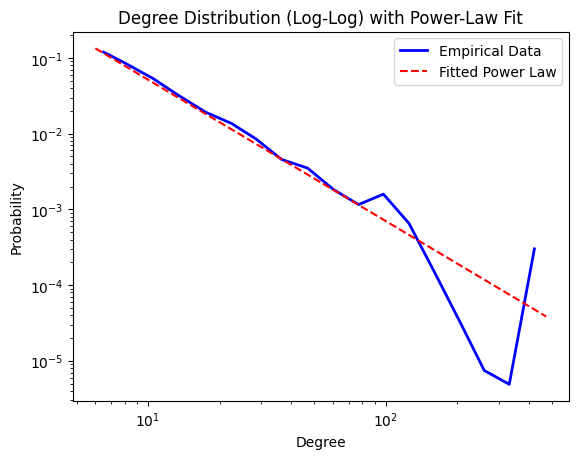

In [ ]:
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Fitted Power Law')
plt.legend()
plt.title("Degree Distribution (Log-Log) with Power-Law Fit")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

##Clique

In [52]:
all_cliques = list(nx.find_cliques(G_coauthor))
print("Number of maximal cliques:", len(all_cliques))

# see the first few cliques:
for i, clique in enumerate(all_cliques[:5]):
    print(f"Clique {i}: {clique}")

largest_clique = max(all_cliques, key=lambda c: len(c))
print("Largest clique (by node count):", largest_clique)
print("Size of the largest clique:", len(largest_clique))

Number of maximal cliques: 4736
Clique 0: ['author_2043', 'author_231', 'author_2041', 'author_2042']
Clique 1: ['author_1676', 'author_11897', 'author_11423', 'author_5585', 'author_5586', 'author_5587', 'author_2122']
Clique 2: ['author_1676', 'author_1180', 'author_2123', 'author_2125', 'author_1408', 'author_565', 'author_2122', 'author_2124']
Clique 3: ['author_1676', 'author_1674', 'author_1673', 'author_1675', 'author_1623', 'author_1622', 'author_621']
Clique 4: ['author_1676', 'author_294', 'author_1408']
Largest clique (by node count): ['author_7271', 'author_10635', 'author_10481', 'author_10777', 'author_10615', 'author_10674', 'author_10567', 'author_10551', 'author_10728', 'author_858', 'author_5496', 'author_10779', 'author_10532', 'author_10678', 'author_10461', 'author_10477', 'author_10663', 'author_10583', 'author_10782', 'author_10479', 'author_10436', 'author_10677', 'author_10580', 'author_10561', 'author_10786', 'author_10607', 'author_10622', 'author_10718', 'au

In [53]:
# Group by paper_id and count the number of authors
paper_author_counts = df_paper_author.groupby("paper_id")["author_id"].count()

# Find the paper_id with the maximum number of authors
paper_with_max_authors = paper_author_counts.idxmax()
max_authors_count = paper_author_counts.max()

print("Paper with the maximum number of authors:", paper_with_max_authors)
print("Number of authors:", max_authors_count)

Paper with the maximum number of authors: paper_2128
Number of authors: 396


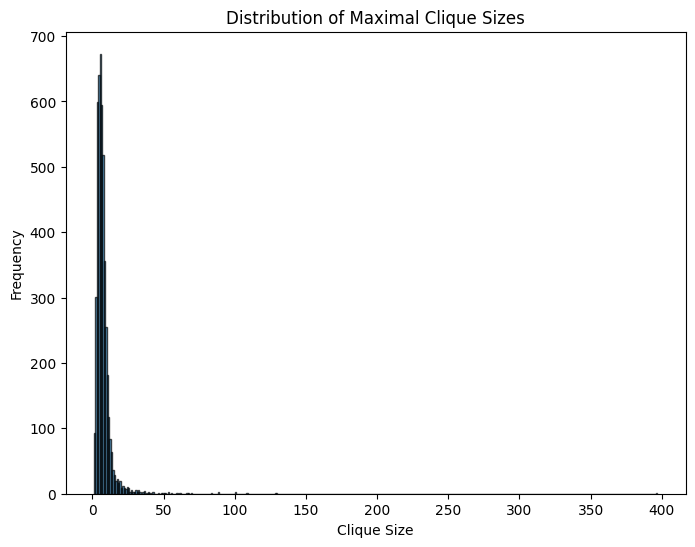

In [54]:
# Suppose 'all_cliques' is your list of maximal cliques
clique_sizes = [len(c) for c in all_cliques]

plt.figure(figsize=(8,6))
plt.hist(clique_sizes, bins=range(1, max(clique_sizes)+2), edgecolor='black', alpha=0.7)
plt.xlabel("Clique Size")
plt.ylabel("Frequency")
plt.title("Distribution of Maximal Clique Sizes")
plt.show()


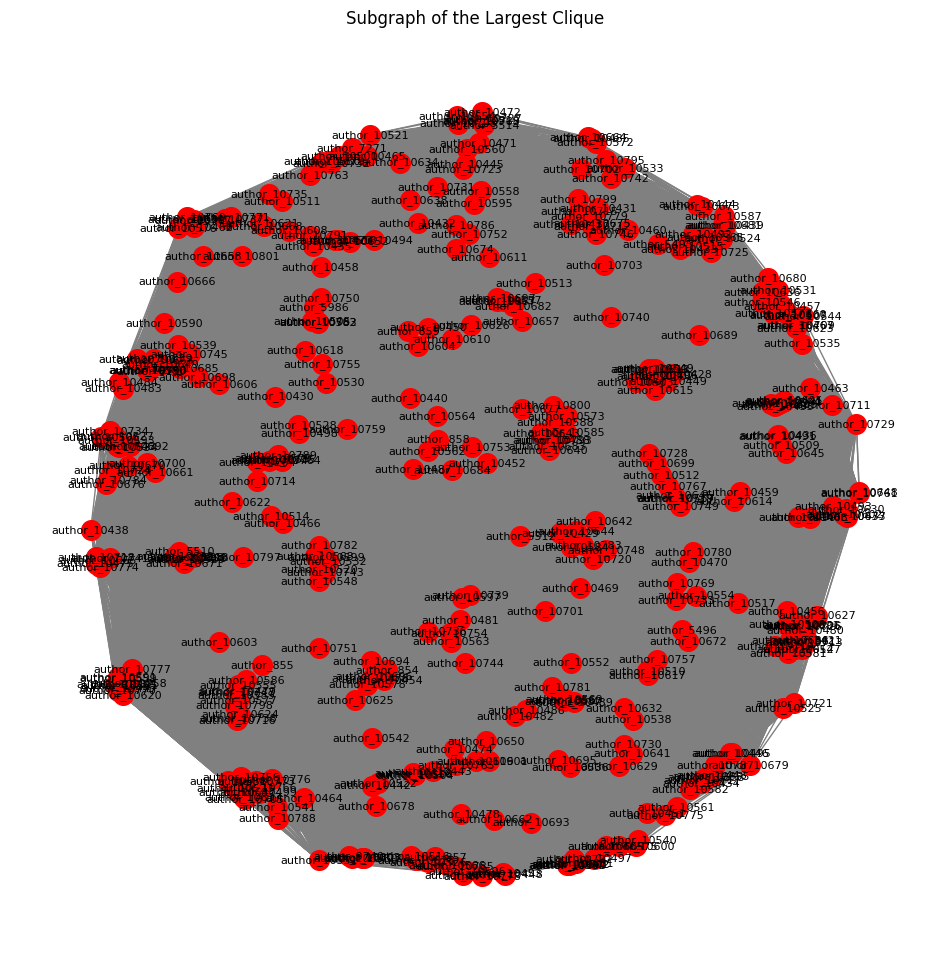

In [58]:
import networkx as nx
import matplotlib.pyplot as plt

largest_clique = max(all_cliques, key=len)
clique_subgraph = G_coauthor.subgraph(largest_clique).copy()

pos = nx.spring_layout(clique_subgraph, seed=42)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(clique_subgraph, pos, node_color='red', node_size=200)
nx.draw_networkx_edges(clique_subgraph, pos, edge_color='gray')
nx.draw_networkx_labels(clique_subgraph, pos, font_size=8)
plt.title("Subgraph of the Largest Clique")
plt.axis('off')
plt.show()


Another visualization

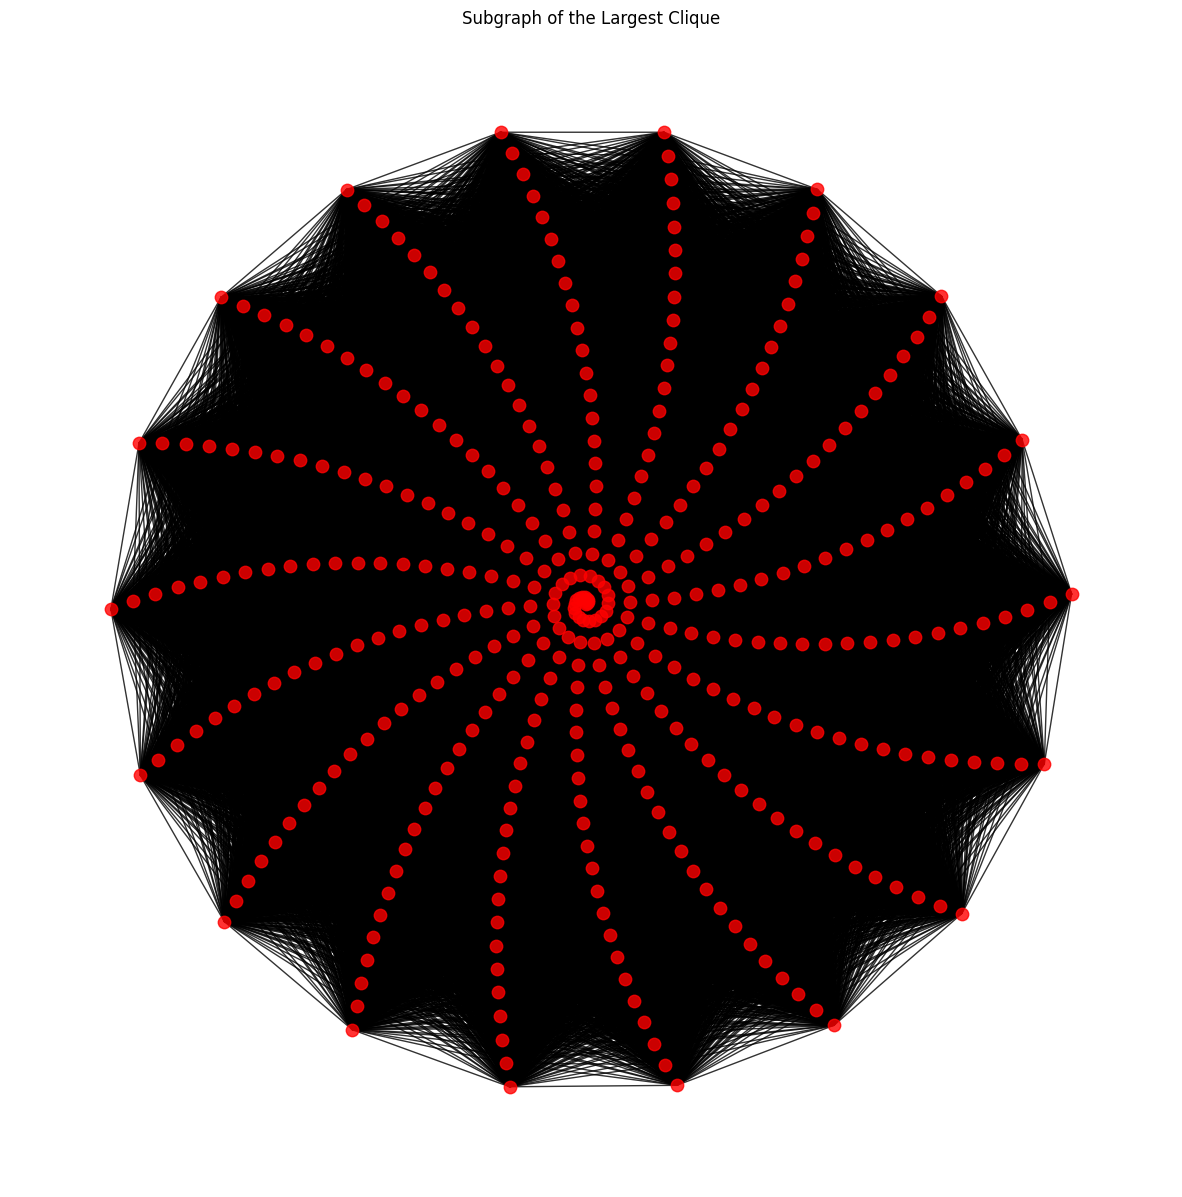

In [65]:
import networkx as nx
import matplotlib.pyplot as plt

# Identify largest clique and build subgraph
largest_clique = max(all_cliques, key=len)
clique_subgraph = G_coauthor.subgraph(largest_clique).copy()

# Try a different layout if you want:
#pos = nx.kamada_kawai_layout(clique_subgraph)
#pos = nx.spring_layout(clique_subgraph, seed=42)
pos = nx.spiral_layout(clique_subgraph)

plt.figure(figsize=(15, 15))
plt.title("Subgraph of the Largest Clique")

# 1. Draw edges first (darker color, thicker, partially opaque)
nx.draw_networkx_edges(
    clique_subgraph, pos,
    edge_color="black",
    width=1.0,
    alpha=0.8
)

# 2. Draw nodes (smaller, partially transparent)
nx.draw_networkx_nodes(
    clique_subgraph, pos,
    node_color="red",
    node_size=80,
    alpha=0.8
)

# 3. (Optional) Draw labels, but this can get cluttered if there are many nodes
#    Uncomment if you really need them:
# nx.draw_networkx_labels(clique_subgraph, pos, font_size=6)

plt.axis("off")
plt.show()
